In [214]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [215]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
%autoreload 2

# Modèle 01

C'est le modèle le plus simple : une masse thermique ($m.C_p$) reliée à la température extérieure à travers une résistance thermique ($S.h$). Linéaire, 1er ordre, équivalent électrique RC.

Rq.: la température extérieure moyenne doit être égale à celle intérieure moyenne.

$$
m.C_p \, \frac{dT}{dt} = -S.h\,( T - T_{ext} )
$$

$m.Cp$ est la masse thermique, $S$ est la surface avec l'extérieure et $h$ le coefficient d'échange.

On pose:
$$
\beta = \frac{S.h}{m.C_p}
$$

et en pasant par la transformée de Fourier, on obtient: 
$$
\tilde T = \frac{\beta}{\beta + 2\pi\, i \, f } \tilde T_{ext}
$$

In [217]:
def model01_apply( beta,  T_ext, sample_freq=15*60 ):
    """ T_ext : np_array
        sample_freq : duré entre les points, en seconde
    """
    # TF (reel)
    TF_ext = np.fft.rfft( T_ext  )
    freq = np.fft.rfftfreq( T_ext.size, d=sample_freq)
    
    # modele
    TF_theo = beta/( beta + 2j*np.pi*freq )*TF_ext

    # TF inverse
    T_theo = np.fft.irfft( TF_theo , n=T_ext.size )
    
    return T_theo

## Fit

In [218]:
from scipy.optimize import fmin

def errorfit( param, T_int, T_ext  ):
    T_theo = model01_apply( param, T_ext )
    return np.sum( (T_int - T_theo)**2 )
  

def model01_fit( T_int, T_ext ):
    
    betaZero = 3e-05

    res = fmin(errorfit, betaZero, disp=True, full_output = True, args=(T_int, T_ext))

    paramOpt, fopt = res[:2]
   
    return paramOpt[0]

## Chargement des données

In [219]:
df_full  = pd.read_pickle( 'weatherdata.pck' )

In [220]:
df = df_full[['T_int', 'temperature']].copy()
df = df.dropna()    

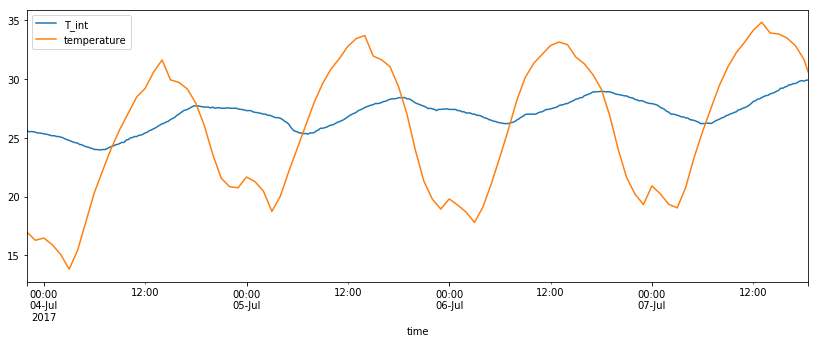

In [221]:
df.plot( figsize=(14, 5) )

In [222]:
# To array :
T_ext = df['temperature'].as_matrix().flatten()
T_int = df['T_int'].as_matrix().flatten()

time_sec = df.index.astype(np.int64) // 10e9

In [223]:
print( T_ext.mean() )
print( T_int.mean() )

25.662958221
26.9718957477


In [224]:
best_beta = model01_fit( T_int, T_ext )

print('---')
print('beta_opt: %e s-1'%best_beta)

print('1/beta : %.1f h'%(1/best_beta / 60/60))

Optimization terminated successfully.
         Current function value: 949.690812
         Iterations: 14
         Function evaluations: 28
---
beta_opt: 1.393359e-05 s-1
1/beta : 19.9 h


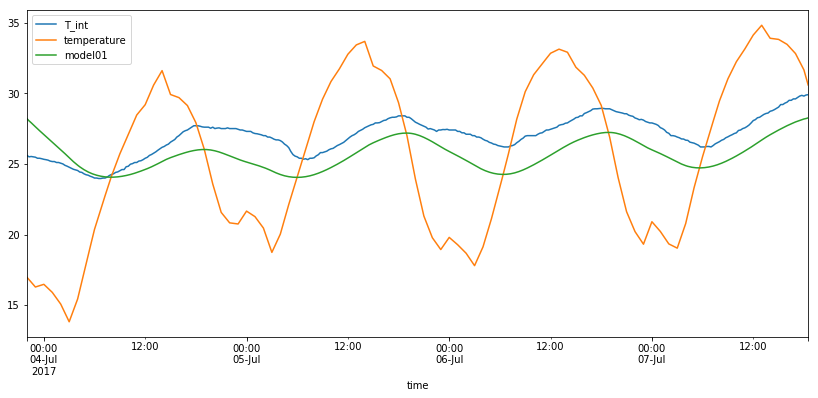

In [225]:
beta = best_beta  # 2.33e-05
T_theo = model01_apply( beta, T_ext )

df['model01'] = T_theo

df.plot( figsize=(14, 6)  )

## Résidus

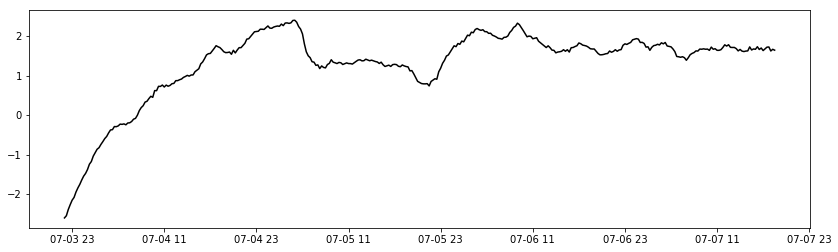

In [226]:
plt.figure( figsize=(14, 4) )
plt.plot_date( df.index,  T_int-T_theo, 'k')

# Avec une température fixe

In [227]:
def model012_apply(  tau_ext, tau_inf, T_inf, T_ext, sample_freq=15*60 ):
    """ T_ext : np_array
        sample_freq : duré entre les points, en seconde
    """
    # TF (reel)
    TF_ext = np.fft.rfft( T_ext  )
    TF_inf =  np.fft.rfft( np.ones_like(T_ext)*T_inf  )
    
    freq = np.fft.rfftfreq( T_ext.size, d=sample_freq)
    
    # modele
    TF_theo = (  tau_ext*TF_ext + tau_inf*TF_inf )/( 2j*np.pi*freq  + tau_ext + tau_inf )

    # TF inverse
    T_theo = np.fft.irfft( TF_theo , n=T_ext.size )
    
    return T_theo

In [228]:
from scipy.optimize import minimize

def errorfit012( param, T_int, T_ext  ):
    T_theo = model012_apply( *param, T_ext )
    return np.sum( (T_int - T_theo)**2 )
  

def model012_fit( T_int, T_ext ):
    
    paramZero = ( 1, 200, 20 )

    res = minimize(errorfit012, paramZero, method='Powell', options={'disp': True}, args=(T_int, T_ext))
    #paramOpt, fopt = res[:2]
   
    return res

In [229]:
res = model012_fit( T_int, T_ext )

print( res.x )

Optimization terminated successfully.
         Current function value: 534.876646
         Iterations: 4
         Function evaluations: 165
[  169.20984894  1615.43814706    27.10900236]


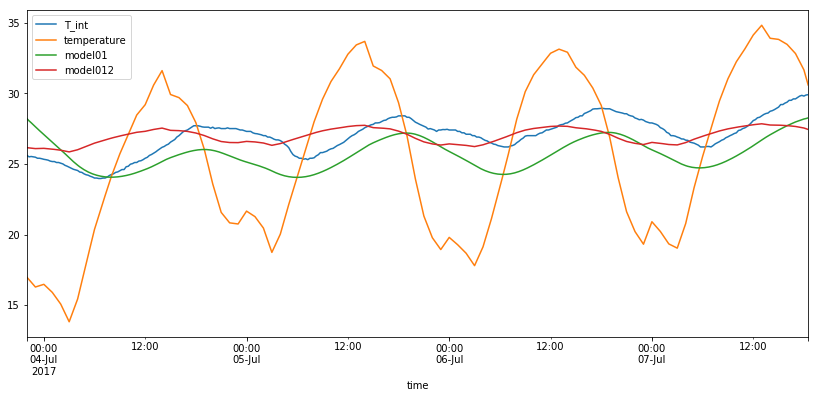

In [230]:
T_theo = model012_apply( *res.x, T_ext )

df['model012'] = T_theo

df.plot( figsize=(14, 6)  )

# Ode

In [231]:
from scipy.integrate import odeint

In [232]:
get_Text = lambda t : np.interp( t, time_sec, T_ext )

flux = df_full['flux_tot'].as_matrix().flatten()


def get_dTdt(  T, t, tau ):
    return ( get_Text(t) - T )/tau

In [233]:
Tzero = 27
tau = 4*3600
res = odeint(get_dTdt, Tzero, time_sec, args=(tau, ) ) #, rtol=1e-2, atol=1e-2, h0=1200)

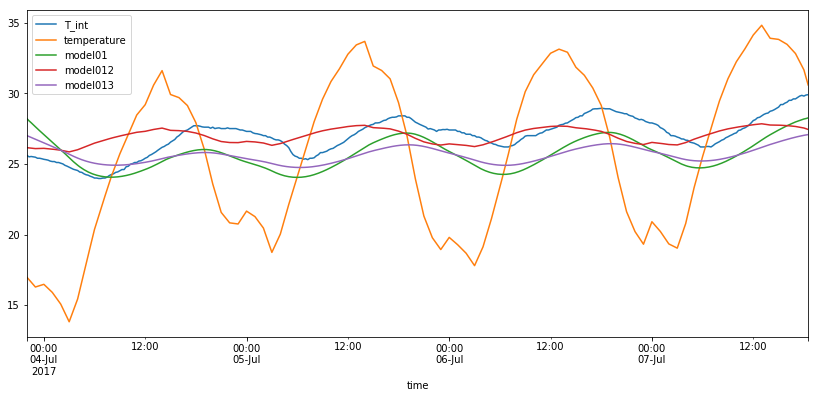

In [234]:
df['model013'] = res
df.plot( figsize=(14, 6)  )

In [235]:
df = df.drop( ['model012'], axis=1)

# Avec le flux solaire

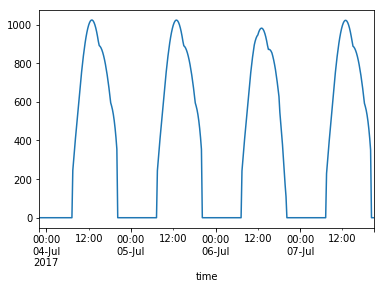

In [236]:
df_full['flux_tot'].plot()